<a href="https://colab.research.google.com/github/dsrajatsrivastava/Fine-Tuning-BERT/blob/master/BERT_NER_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
data = pd.read_csv("/content/ner_dataset.csv", encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.count()

Sentence #      47959
Word          1048575
POS           1048575
Tag           1048575
dtype: int64

In [ ]:
print("Number of tags: {}".format(len(data.Tag.unique())))
frequencies = data.Tag.value_counts()
d1=pd.DataFrame(frequencies)

Number of tags: 17


In [ ]:
frequencies1 = data.Tag.value_counts().sum()
frequencies1

1048575

In [ ]:
d1["percent"]=d1['Tag']/frequencies1
d1

,Tag,percent
O,887908,0.846776
B-geo,37644,0.035900
B-tim,20333,0.019391
B-org,20143,0.019210
I-per,17251,0.016452
B-per,16990,0.016203
I-org,16784,0.016006
B-gpe,15870,0.015135
I-geo,7414,0.007071
I-tim,6528,0.006226


In [ ]:
#There are 8 category tags, each with a "beginning" and "inside" variant, and the "outside" tag. It is not really clear what these tags mean - "geo" probably stands for geographical entity, "gpe" for geopolitical entity, and so on.

tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count
    continue

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('geo', 45058), ('org', 36927), ('per', 34241), ('tim', 26861), ('gpe', 16068), ('art', 699), ('eve', 561), ('nat', 252)]


In [ ]:
#Let's remove "art", "eve" and "nat" named entities, as performance on them will probably be not comparable to the other named entities.

entities_to_remove = ["B-art", "I-art", "B-eve", "I-eve", "B-nat", "I-nat","I-gpe"]
data = data[~data.Tag.isin(entities_to_remove)]
data.head()


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [ ]:
data.shape

(1046865, 4)

In [ ]:
#original_data_with_missing
old_data=data.copy()

In [ ]:
# pandas has a very handy "forward fill" function to fill missing values based on the last upper non-nan value
data = data.fillna(method='ffill')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
# EDA for the cleaned data
data['Tag']=data['Tag'].str.upper()

In [ ]:
data1=data.copy()


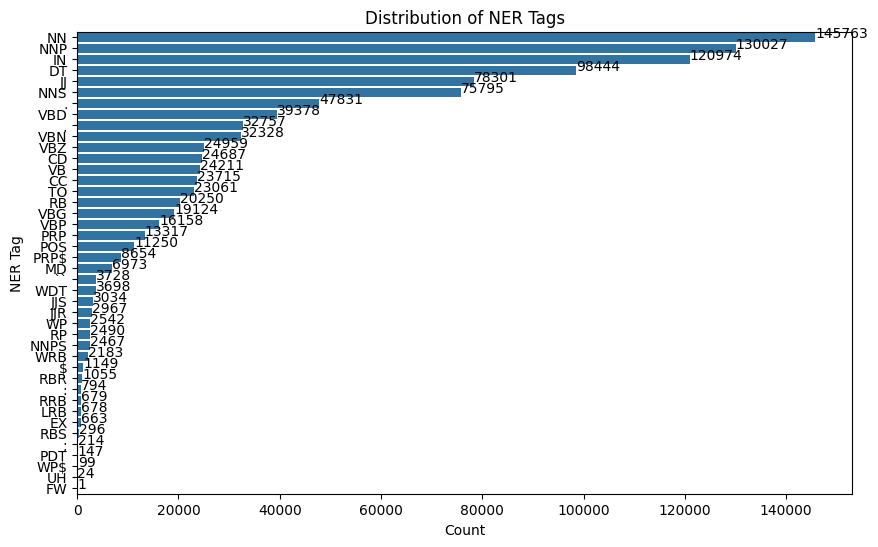

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Distribution of NER tags
plt.figure(figsize=(10, 6))
sns.countplot(y='POS', data=data, order = data['POS'].value_counts().index)
plt.title('Distribution of NER Tags')
plt.xlabel('Count')
plt.ylabel('NER Tag')

# Add counts on top of the bars with a gap
for i in range(len(data['POS'].value_counts())):
    plt.text(data['POS'].value_counts()[i] + 1.5, i, data['POS'].value_counts()[i], ha='left')

plt.show()

In [ ]:
# Get value counts for the 'POS' column
ner_tag_counts = data['POS'].value_counts()

# Create a DataFrame to display the counts
ner_tag_table = pd.DataFrame({'NER Tag': ner_tag_counts.index, 'Count': ner_tag_counts.values})

# Sort the table by count in descending order
ner_tag_table = ner_tag_table.sort_values(by='Count', ascending=False)

# Display the table
print(ner_tag_table)

   NER Tag   Count
0       NN  145763
1      NNP  130027
2       IN  120974
3       DT   98444
4       JJ   78301
5      NNS   75795
6        .   47831
7      VBD   39378
8        ,   32757
9      VBN   32328
10     VBZ   24959
11      CD   24687
12      VB   24211
13      CC   23715
14      TO   23061
15      RB   20250
16     VBG   19124
17     VBP   16158
18     PRP   13317
19     POS   11250
20    PRP$    8654
21      MD    6973
22      ``    3728
23     WDT    3698
24     JJS    3034
25     JJR    2967
26      WP    2542
27      RP    2490
28    NNPS    2467
29     WRB    2183
30       $    1149
31     RBR    1055
32       :     794
33     RRB     679
34     LRB     678
35      EX     663
36     RBS     296
37       ;     214
38     PDT     147
39     WP$      99
40      UH      24
41      FW       1


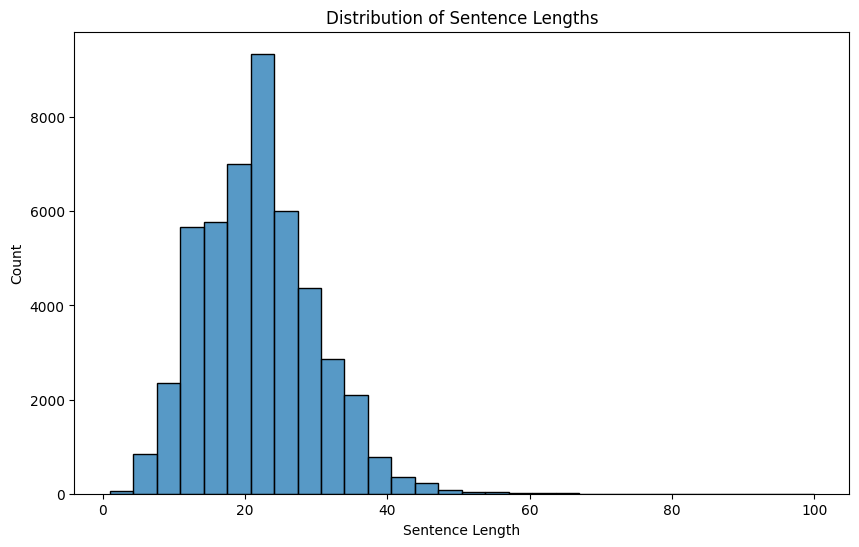

        Sentence #  Sentence Length
0      Sentence: 1               24
1     Sentence: 10               25
2    Sentence: 100               32
3   Sentence: 1000               11
4  Sentence: 10000               35


In [ ]:
# Distribution of sentence lengths
sentence_lengths = data.groupby('Sentence #')['Word'].count()
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.show()
# Create DataFrame for sentence lengths
sentence_lengths_df = pd.DataFrame({'Sentence #': sentence_lengths.index, 'Sentence Length': sentence_lengths.values})

# Display the DataFrame
print(sentence_lengths_df.head())

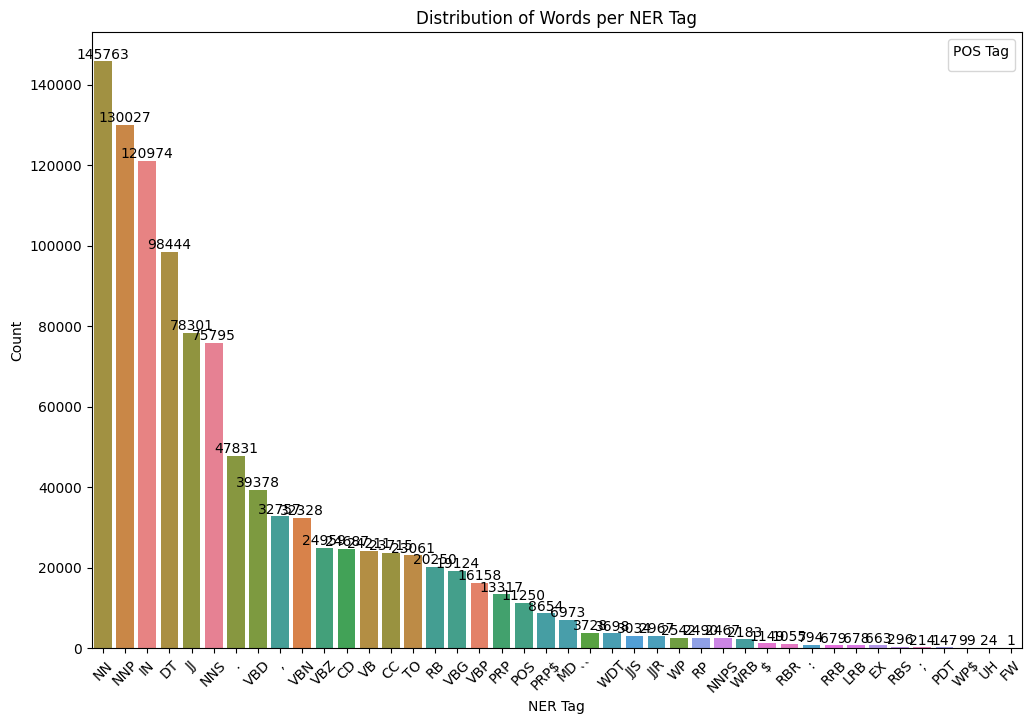

In [ ]:
# Distribution of words per NER tag
plt.figure(figsize=(12, 8))
sns.countplot(x='POS', data=data, hue='POS', order = data['POS'].value_counts().index)
plt.title('Distribution of Words per NER Tag')
plt.xlabel('NER Tag')
plt.ylabel('Count')
plt.legend(title='POS Tag')
plt.xticks(rotation=45)

# Add data labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()



In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Summary statistics for all columns
print("\nSummary Statistics for  Columns:")
print(data1.describe(include="all"))



Summary Statistics for  Columns:
             Sentence #     Word      POS      Tag
count           1046865  1046865  1046865  1046865
unique            47920    34989       42       10
top     Sentence: 22480      the       NN        O
freq                100    52572   145763   887908


In [116]:
data.head()

,sentence_id,words,POS,label
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [ ]:
data['Sentence #'] = LabelEncoder().fit_transform(data['Sentence #'])


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [119]:
data['sentence_id'] = LabelEncoder().fit_transform(data['sentence_id'])
data.head()

,sentence_id,words,POS,label
0,0,Thousands,NNS,O
1,0,of,IN,O
2,0,demonstrators,NNS,O
3,0,have,VBP,O
4,0,marched,VBN,O


In [121]:
data['label'] = data['label'].str.upper()

In [ ]:
data.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [ ]:
# Make necessary changes to use simple transformer model
data.rename(columns = {'Sentence #':'sentence_id',
                       'Word':'words',
                       'Tag':'label'},inplace = True)
labels = data['label'].unique().tolist()
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-PER',
 'I-TIM']

In [122]:
X = data[['sentence_id','words']]
y = data['label']


In [124]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
train_data = pd.DataFrame({"sentence_id":X_train["sentence_id"],"words":X_train["words"],"labels":y_train})
test_data = pd.DataFrame({"sentence_id":X_test["sentence_id"],"words":X_test["words"],"labels":y_test})

In [125]:
labels = data['label'].unique().tolist()
labels

['O',
 'B-GEO',
 'B-GPE',
 'B-PER',
 'I-GEO',
 'B-ORG',
 'I-ORG',
 'B-TIM',
 'I-PER',
 'I-TIM']

In [126]:
from simpletransformers.ner import NERModel , NERArgs

In [127]:
args = NERArgs()
args.num_train_epochs = 1
args.learning_rate = 1e-4
args.overwrite_output_dir = True
args.train_batch_size = 32
args.eval_batch_size = 32

In [128]:
model = NERModel('bert','bert-base-cased',labels = labels , args = args)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [129]:
model.train_model(train_data , eval_data = test_data , acc = accuracy_score)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/1498 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


(1498, 0.17870275816011014)

In [130]:
result, model_outputs, preds_list = model.eval_model(test_data)

/usr/local/lib/python3.10/dist-packages/simpletransformers/ner/ner_utils.py:190: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  return [


  0%|          | 0/3 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/1479 [00:00<?, ?it/s]

In [131]:
result

{'eval_loss': 0.15412884061001217,
 'precision': 0.8299891765881275,
 'recall': 0.7777748881722667,
 'f1_score': 0.8030341679532791}

In [132]:
data1.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [134]:
# Fine Tuning bert model on our data

# let's create a new column called "sentence" which groups the words by sentence
data1['sentence'] = data1[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Word'].transform(lambda x: ' '.join(x))
# let's also create a new column called "word_labels" which groups the tags by sentence
data1['word_labels'] = data1[['Sentence #','Word','Tag']].groupby(['Sentence #'])['Tag'].transform(lambda x: ','.join(x))
data1.head()

,Sentence #,Word,POS,Tag,sentence,word_labels
0,Sentence: 1,Thousands,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
1,Sentence: 1,of,IN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
2,Sentence: 1,demonstrators,NNS,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
3,Sentence: 1,have,VBP,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
4,Sentence: 1,marched,VBN,O,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."


In [135]:
label2id = {k: v for v, k in enumerate(data1.Tag.unique())}
id2label = {v: k for v, k in enumerate(data1.Tag.unique())}
label2id

{'O': 0,
 'B-GEO': 1,
 'B-GPE': 2,
 'B-PER': 3,
 'I-GEO': 4,
 'B-ORG': 5,
 'I-ORG': 6,
 'B-TIM': 7,
 'I-PER': 8,
 'I-TIM': 9}

In [137]:
data1 = data1[["sentence", "word_labels"]].drop_duplicates().reset_index(drop=True)
data1.head()

,sentence,word_labels
0,Thousands of demonstrators have marched throug...,"O,O,O,O,O,O,B-GEO,O,O,O,O,O,B-GEO,O,O,O,O,O,B-..."
1,Families of soldiers killed in the conflict jo...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-PER,O,O,..."
2,They marched from the Houses of Parliament to ...,"O,O,O,O,O,O,O,O,O,O,O,B-GEO,I-GEO,O"
3,"Police put the number of marchers at 10,000 wh...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O"
4,The protest comes on the eve of the annual con...,"O,O,O,O,O,O,O,O,O,O,O,B-GEO,O,O,B-ORG,I-ORG,O,..."


In [138]:
len(data1)

47571

In [139]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
MAX_GRAD_NORM = 10
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [140]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    """
    Word piece tokenization makes it difficult to match word labels
    back up with individual word pieces. This function tokenizes each
    word one at a time so that it is easier to preserve the correct
    label for each subword. It is, of course, a bit slower in processing
    time, but it will help our model achieve higher accuracy.
    """

    tokenized_sentence = []
    labels = []

    sentence = sentence.strip()

    for word, label in zip(sentence.split(), text_labels.split(",")):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


In [141]:
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: tokenize (and adapt corresponding labels)
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index]
        tokenized_sentence, labels = tokenize_and_preserve_labels(sentence, word_labels, self.tokenizer)

        # step 2: add special tokens (and corresponding labels)
        tokenized_sentence = ["[CLS]"] + tokenized_sentence + ["[SEP]"] # add special tokens
        labels.insert(0, "O") # add outside label for [CLS] token
        labels.insert(-1, "O") # add outside label for [SEP] token

        # step 3: truncating/padding
        maxlen = self.max_len

        if (len(tokenized_sentence) > maxlen):
          # truncate
          tokenized_sentence = tokenized_sentence[:maxlen]
          labels = labels[:maxlen]
        else:
          # pad
          tokenized_sentence = tokenized_sentence + ['[PAD]'for _ in range(maxlen - len(tokenized_sentence))]
          labels = labels + ["O" for _ in range(maxlen - len(labels))]

        # step 4: obtain the attention mask
        attn_mask = [1 if tok != '[PAD]' else 0 for tok in tokenized_sentence]

        # step 5: convert tokens to input ids
        ids = self.tokenizer.convert_tokens_to_ids(tokenized_sentence)

        label_ids = [label2id[label] for label in labels]
        # the following line is deprecated
        #label_ids = [label if label != 0 else -100 for label in label_ids]

        return {
              'ids': torch.tensor(ids, dtype=torch.long),
              'mask': torch.tensor(attn_mask, dtype=torch.long),
              #'token_type_ids': torch.tensor(token_ids, dtype=torch.long),
              'targets': torch.tensor(label_ids, dtype=torch.long)
        }

    def __len__(self):
        return self.len


In [147]:
train_size = 0.7
train_dataset = data1.sample(frac=train_size,random_state=200)
test_dataset = data1.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(data1.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (47571, 2)
TRAIN Dataset: (33300, 2)
TEST Dataset: (14271, 2)


In [148]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [149]:
model = BertForTokenClassification.from_pretrained('bert-base-uncased',
                                                   num_labels=len(id2label),
                                                   id2label=id2label,
                                                   label2id=label2id)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [150]:
ids = training_set[0]["ids"].unsqueeze(0)
mask = training_set[0]["mask"].unsqueeze(0)
targets = training_set[0]["targets"].unsqueeze(0)
ids = ids.to(device)
mask = mask.to(device)
targets = targets.to(device)
outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
initial_loss = outputs[0]
initial_loss

tensor(2.3727, device='cuda:0', grad_fn=<NllLossBackward0>)

In [151]:
tr_logits = outputs[1]
tr_logits.shape

torch.Size([1, 128, 10])

In [152]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [153]:
# Defining the training function on the 80% of the dataset for tuning the bert model
def train(epoch):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    # put model in training mode
    model.train()

    for idx, batch in enumerate(training_loader):

        ids = batch['ids'].to(device, dtype = torch.long)
        mask = batch['mask'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
        loss, tr_logits = outputs.loss, outputs.logits
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)

        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")

        # compute training accuracy
        flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
        active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
        targets = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)

        tr_preds.extend(predictions)
        tr_labels.extend(targets)

        tmp_tr_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [154]:
for epoch in range(EPOCHS):
    print(f"Training epoch: {epoch + 1}")
    train(epoch)

Training epoch: 1
Training loss per 100 training steps: 2.4296505451202393
Training loss per 100 training steps: 0.43157665770832854
Training loss per 100 training steps: 0.27082364054498687
Training loss per 100 training steps: 0.21139570361504523
Training loss per 100 training steps: 0.1770045282063713
Training loss per 100 training steps: 0.15573441464418616
Training loss per 100 training steps: 0.1393768637477515
Training loss per 100 training steps: 0.127239568078274
Training loss per 100 training steps: 0.11744797156778362
Training loss per 100 training steps: 0.11003889899998573
Training loss per 100 training steps: 0.10405920538679138
Training loss per 100 training steps: 0.09875012732548241
Training loss per 100 training steps: 0.09398472927073381
Training loss per 100 training steps: 0.0901281524247001
Training loss per 100 training steps: 0.0869927639663512
Training loss per 100 training steps: 0.08373204684896342
Training loss per 100 training steps: 0.08079016600054299
Tra

In [155]:
def valid(model, testing_loader):
    # put model in evaluation mode
    model.eval()

    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []

    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):

            ids = batch['ids'].to(device, dtype = torch.long)
            mask = batch['mask'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            outputs = model(input_ids=ids, attention_mask=mask, labels=targets)
            loss, eval_logits = outputs.loss, outputs.logits

            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += targets.size(0)

            if idx % 100==0:
                loss_step = eval_loss/nb_eval_steps
                print(f"Validation loss per 100 evaluation steps: {loss_step}")

            # compute evaluation accuracy
            flattened_targets = targets.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            # now, use mask to determine where we should compare predictions with targets (includes [CLS] and [SEP] token predictions)
            active_accuracy = mask.view(-1) == 1 # active accuracy is also of shape (batch_size * seq_len,)
            targets = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)

            eval_labels.extend(targets)
            eval_preds.extend(predictions)

            tmp_eval_accuracy = accuracy_score(targets.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    #print(eval_labels)
    #print(eval_preds)

    labels = [id2label[id.item()] for id in eval_labels]
    predictions = [id2label[id.item()] for id in eval_preds]

    #print(labels)
    #print(predictions)

    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions

In [156]:
labels, predictions = valid(model, testing_loader)

Validation loss per 100 evaluation steps: 0.003129858523607254
Validation loss per 100 evaluation steps: 0.025292843054504004
Validation loss per 100 evaluation steps: 0.023932873434517464
Validation loss per 100 evaluation steps: 0.023632895463234063
Validation loss per 100 evaluation steps: 0.023123217488872323
Validation loss per 100 evaluation steps: 0.023788613335079232
Validation loss per 100 evaluation steps: 0.02349607341924708
Validation loss per 100 evaluation steps: 0.023508320640283173
Validation loss per 100 evaluation steps: 0.023422242474910315
Validation loss per 100 evaluation steps: 0.024157458679607724
Validation loss per 100 evaluation steps: 0.024240451740974327
Validation loss per 100 evaluation steps: 0.02439305329937136
Validation loss per 100 evaluation steps: 0.024140494965278026
Validation loss per 100 evaluation steps: 0.02432334370990357
Validation loss per 100 evaluation steps: 0.024495628784343308
Validation loss per 100 evaluation steps: 0.02427298220699

In [157]:
from seqeval.metrics import classification_report

print(classification_report([labels], [predictions]))

              precision    recall  f1-score   support

         GEO       0.86      0.86      0.86     17166
         GPE       0.94      0.92      0.93      5144
         ORG       0.66      0.66      0.66      9733
         PER       0.73      0.83      0.78      7883
         TIM       0.83      0.83      0.83      6562

   micro avg       0.80      0.81      0.81     46488
   macro avg       0.80      0.82      0.81     46488
weighted avg       0.80      0.81      0.81     46488



In [158]:
sentence = "India has a capital called Mumbai. On wednesday, the president will give a presentation"

inputs = tokenizer(sentence, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")

# move to gpu
ids = inputs["input_ids"].to(device)
mask = inputs["attention_mask"].to(device)
# forward pass
outputs = model(ids, mask)
logits = outputs[0]

active_logits = logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size*seq_len,) - predictions at the token level

tokens = tokenizer.convert_ids_to_tokens(ids.squeeze().tolist())
token_predictions = [id2label[i] for i in flattened_predictions.cpu().numpy()]
wp_preds = list(zip(tokens, token_predictions)) # list of tuples. Each tuple = (wordpiece, prediction)

word_level_predictions = []
for pair in wp_preds:
  if (pair[0].startswith(" ##")) or (pair[0] in ['[CLS]', '[SEP]', '[PAD]']):
    # skip prediction
    continue
  else:
    word_level_predictions.append(pair[1])

# we join tokens, if they are not special ones
str_rep = " ".join([t[0] for t in wp_preds if t[0] not in ['[CLS]', '[SEP]', '[PAD]']]).replace(" ##", "")
print(str_rep)
print(word_level_predictions)

india has a capital called mumbai . on wednesday , the president will give a presentation
['B-GEO', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'B-TIM', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [159]:
from transformers import pipeline

pipe = pipeline(task="token-classification", model=model.to("cpu"), tokenizer=tokenizer, aggregation_strategy="simple")
pipe("My name is Rajat and Gurgaon is a city")

[{'entity_group': 'PER',
  'score': 0.69610316,
  'word': 'raja',
  'start': None,
  'end': None},
 {'entity_group': 'PER',
  'score': 0.4548923,
  'word': '##t',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.7549975,
  'word': 'gu',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.81145,
  'word': '##rga',
  'start': None,
  'end': None},
 {'entity_group': 'GEO',
  'score': 0.740689,
  'word': '##on',
  'start': None,
  'end': None}]

In [160]:
!sudo apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [161]:
from huggingface_hub import notebook_login

notebook_login()

In [166]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# load the model from disk
#loaded_model = pickle.load(open(model, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)